# Geometry computations: Example 5

Here we compute some simple geometries based on keypoints in a single image. 

IMPORTANT Note that you can use multiprocessing function to performed these and many other operations in whole videos. 

In [1]:
from simba.mixins.geometry_mixin import GeometryMixin
from simba.mixins.config_reader import ConfigReader
from simba.utils.read_write import read_df, read_frm_of_video
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 
import os
import cv2
dpi = matplotlib.rcParams['figure.dpi']

In [2]:
#AS AN EXAMPLE, WE WILL PULL THE DATA FROM A SPECIFIED SIMBA PROJECT, VIDEO AND FRAME, WHICH WE DEFINE HERE
FRAME_IDX = 70
VIDEO_NAME = 'Together_1'
CONFIG_PATH = r'/Users/simon/Desktop/envs/simba/troubleshooting/two_black_animals_14bp/project_folder/project_config.ini'

In [3]:
#WE READ IN THE SIMBA PROJECT, AND THE FRAME FOR THE SPECIFIED VIDEO FOR VISUALIZATION PURPOSES
config = ConfigReader(config_path=CONFIG_PATH, read_video_info=False)

In [4]:
#A HELPER FUNCTION TO HELP US VIEW THE GEOMETRIES CREATED IN THE BELOW CALLS WITHIN A JUPYTHER NOTEBOOK
def view_image(img):
    height, width, depth = img.shape
    figsize = width / float(dpi), height / float(dpi)
    plt.figure(figsize=figsize)
    plt.axis('off')
    plt.imshow(img)
    plt.show()

In [5]:
#WE READ IN THE POSE-ESTIMATION DATA FOR THE SPECIFIED VIDEO AND FRAME, AND CONVERT THE DATA INTO ARRAYS
data_path = os.path.join(config.outlier_corrected_dir, VIDEO_NAME + f'.{config.file_type}')
df = read_df(data_path, file_type=config.file_type)
frame_data = df.iloc[FRAME_IDX]
animal_1_data = df[[x for x in df.columns if x in config.animal_bp_dict['Animal_1']['X_bps'] + config.animal_bp_dict['Animal_1']['Y_bps']]].values
animal_2_data = df[[x for x in df.columns if x in config.animal_bp_dict['Animal_2']['X_bps'] + config.animal_bp_dict['Animal_2']['Y_bps']]].values
animal_1_frm = animal_1_data[FRAME_IDX, :].reshape(1, -1, 2)
animal_2_frm = animal_2_data[FRAME_IDX, :].reshape(1, -1, 2)

In [6]:
# WE CONVERT THE POSE-ESTIMATION KEY-POINTS TO POLYGON GEOMETRIES. 
# WE USE THE PARALLEL OFFSET AND PIXELS PER MILLIMETER CONVERTION FACTOR TO BUFFER THE GEOMETRIES 20MM
animal_1_geo = GeometryMixin().bodyparts_to_polygon(animal_1_frm, parallel_offset=30, pixels_per_mm=1)[0]
animal_2_geo = GeometryMixin().bodyparts_to_polygon(animal_2_frm, parallel_offset=30, pixels_per_mm=1)[0]

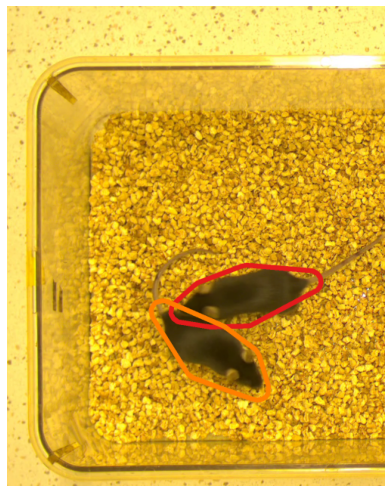

In [7]:
# WE VIEW THE GEOMETRIES ASSOCIATED WITH THE TWO ANIMALS
frm = read_frm_of_video(os.path.join(config.video_dir, VIDEO_NAME +'.mp4'), frame_index=FRAME_IDX)
img = GeometryMixin.view_shapes([animal_1_geo, animal_2_geo], bg_img=frm, thickness=12, size=500)
view_image(img)

In [8]:
#CHECK IF GEOMETRY FOR ANIMAL 2 FULLY COVERS THE GEOMETRY OF ANIMAL 1 
GeometryMixin.is_shape_covered(shapes=[animal_1_geo, animal_2_geo])

False

In [9]:
#CHECK IF GEOMETRY FOR ANIMAL 1 AND ANIMAL 2 ARE OVERLAPPING AT ANY POINT
bool(GeometryMixin.compute_shape_overlap(shapes=[animal_1_geo, animal_2_geo]))

True

In [10]:
#GET THE AREA OF THE ANIMAL 2 GEOMETRY
GeometryMixin.area(shape=animal_2_geo, pixels_per_mm=25)

1726.081790790042

In [11]:
#GET THE CENTER PIXEL LOCATION OF THE ANIMAL 1 GEOMETRY
GeometryMixin.get_center(shape=animal_1_geo)

array([635.48619104, 778.19363084])

In [12]:
#GET THE BRIGHTNESS INSIDE THE ANIMAL 1 AND ANIMAL 2 GEOMETRIES
GeometryMixin.get_geometry_brightness_intensity(img=frm, geometries=[animal_1_geo, animal_2_geo])

[64.0, 67.0]

In [13]:
#GET THE HAUSDORFF DISTANCE BETWEEN THE ANIMAL 1 AND ANIMAL 2 GEOMETRIES
GeometryMixin.hausdorff_distance(geometries=[[animal_1_geo, animal_2_geo]])

array([263.93844949])

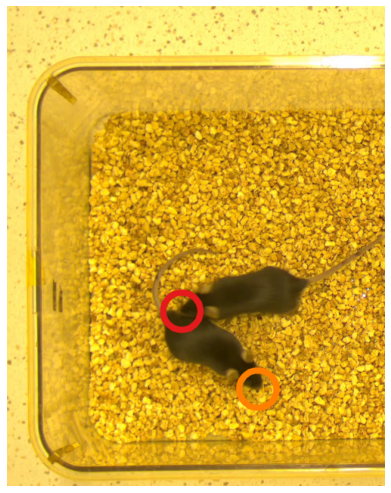

In [14]:
# NOTE, WE DON'T HAVE TO WORK WITH POLYGONS, WE COULD ALSO WORK WITH E.G. CIRCLES. HERE WE CREATE TWO CIRCLES
# CENTERED AROUND THE TWO ANIMALS NOSES WITH A 5CM BUFFER

nose_circle_1 = GeometryMixin.bodyparts_to_circle(animal_1_frm[0][0], parallel_offset=50, pixels_per_mm=1)
nose_circle_2 = GeometryMixin.bodyparts_to_circle(animal_2_frm[0][0], parallel_offset=50, pixels_per_mm=1)
frm = read_frm_of_video(os.path.join(config.video_dir, VIDEO_NAME +'.mp4'), frame_index=FRAME_IDX)
img = GeometryMixin.view_shapes([nose_circle_1, nose_circle_2], bg_img=frm, thickness=16, size=500)
view_image(img)

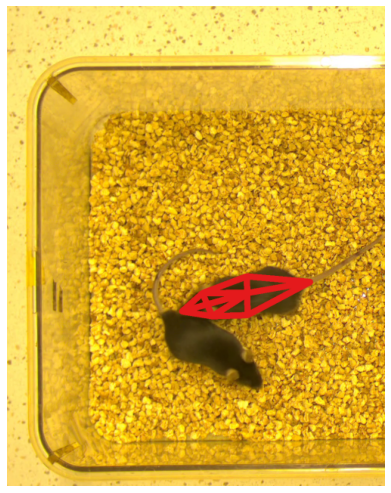

In [15]:
#ANOTHER ALTERNATIVE IS TO WORK WITH "SKELETONS". HERE WE DEFINE AND DRAW A SKELETION ON ONE OF THE ANIMALS
skeleton = np.array([[animal_1_frm[0][0], animal_1_frm[0][1]],
                     [animal_1_frm[0][0], animal_1_frm[0][2]],
                     [animal_1_frm[0][1], animal_1_frm[0][3]],
                     [animal_1_frm[0][0], animal_1_frm[0][3]],
                     [animal_1_frm[0][2], animal_1_frm[0][3]],
                     [animal_1_frm[0][1], animal_1_frm[0][4]],
                     [animal_1_frm[0][5], animal_1_frm[0][2]],
                     [animal_1_frm[0][2], animal_1_frm[0][5]],
                     [animal_1_frm[0][5], animal_1_frm[0][6]],
                     [animal_1_frm[0][4], animal_1_frm[0][6]],
                     [animal_1_frm[0][3], animal_1_frm[0][6]]]).reshape(1, -1, 2)
skeleton = GeometryMixin.bodyparts_to_multistring_skeleton(skeleton)
frm = read_frm_of_video(os.path.join(config.video_dir, VIDEO_NAME +'.mp4'), frame_index=FRAME_IDX)
img = GeometryMixin.view_shapes([skeleton], bg_img=frm, thickness=16, size=500)
view_image(img)

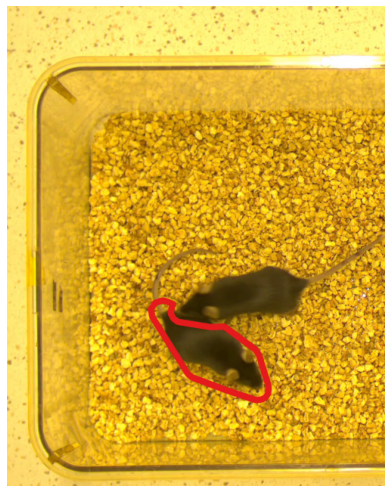

In [16]:
# COMPUTE THE DIFFERENCE BETWEEN THE ANIMAL 2 GEOMETRY AND THE ANIMAL 1 GEOMETRY. 
# I.E., RETURN THE ANIMAL 2 GEOMETRY WHICH IS **NOT** PART OF THE ANIMAL 1 GEOMETRY
difference = GeometryMixin.difference(shapes=[animal_2_geo, animal_1_geo])
frm = read_frm_of_video(os.path.join(config.video_dir, VIDEO_NAME +'.mp4'), frame_index=FRAME_IDX)
img = GeometryMixin.view_shapes([difference], bg_img=frm, thickness=16, size=500)
view_image(img)

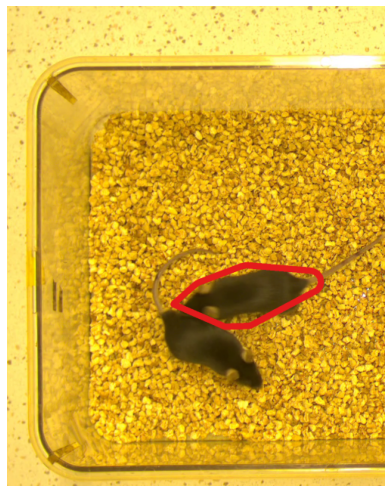

In [17]:
# CONVERSELY, COMPUTE THE DIFFERENCE BETWEEN THE ANIMAL 1 GEOMETRY AND THE ANIMAL 2 GEOMETRY. 
# I.E., RETURN THE ANIMAL 1 GEOMETRY WHICH IS **NOT** PART OF THE ANIMAL 2 GEOMETRY
difference = GeometryMixin.difference(shapes=[animal_1_geo, animal_2_geo])
frm = read_frm_of_video(os.path.join(config.video_dir, VIDEO_NAME +'.mp4'), frame_index=FRAME_IDX)
img = GeometryMixin.view_shapes([difference], bg_img=frm, thickness=16, size=500)
view_image(img)

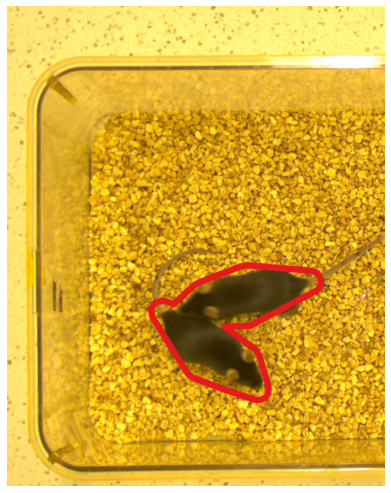

In [18]:
# COMPUTE THE UNION OF THE ANIMAL 1 GEOMETRY AND THE ANIMAL 2 GEOMETRY. 
# I.E., GET ONE SHAPE THAT ENCOMPASSES BOTH THE ANIMAL 1 GEOMETRY AND THE ANIMAL 2 GEOMETRY.
union = GeometryMixin.union(shapes=[animal_2_geo, animal_1_geo])
frm = read_frm_of_video(os.path.join(config.video_dir, VIDEO_NAME +'.mp4'), frame_index=FRAME_IDX)
img = GeometryMixin.view_shapes([union], bg_img=frm, thickness=16, size=500)
view_image(img)

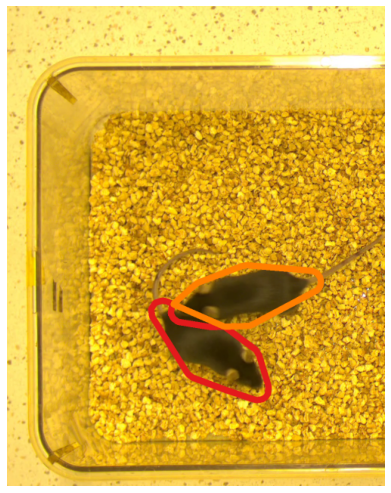

In [19]:
# COMPUTE THE SYMMETRIC DIFFERENCE OF THE ANIMAL 1 GEOMETRY AND THE ANIMAL 2 GEOMETRY. 
# I.E., GET TWO SHAPES REPRESENTING THE TWO ANIMALS WHERE THE TWO SHAPES DO NOT OVERLAP

symmetric_difference = GeometryMixin.symmetric_difference(shapes=[animal_2_geo, animal_1_geo])
frm = read_frm_of_video(os.path.join(config.video_dir, VIDEO_NAME +'.mp4'), frame_index=FRAME_IDX)
img = GeometryMixin.view_shapes(symmetric_difference, bg_img=frm, thickness=16, size=500)
view_image(img)

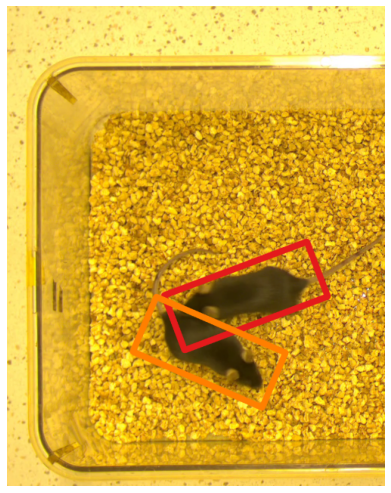

In [20]:
# FORCE THE ANIMAL POLYGONS INTO RECTANGLES. 
# THE RECTANGLES WILL BE THE MINIMUM SIZE ENCOMPASSING ALL VERICES OF THE POLYGON GEOMETRIES
animal_1_rect = GeometryMixin.minimum_rotated_rectangle(shape=animal_1_geo)
animal_2_rect = GeometryMixin.minimum_rotated_rectangle(shape=animal_2_geo)
frm = read_frm_of_video(os.path.join(config.video_dir, VIDEO_NAME +'.mp4'), frame_index=FRAME_IDX)
img = GeometryMixin.view_shapes([animal_1_rect, animal_2_rect], bg_img=frm, thickness=16, size=500)
view_image(img)

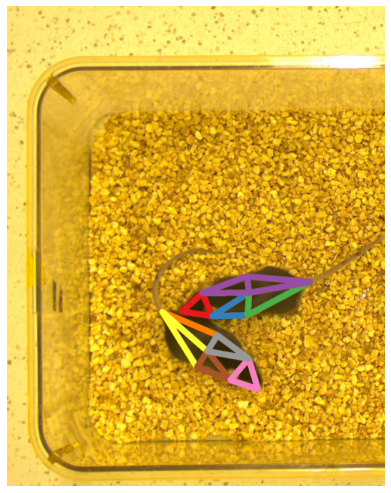

In [21]:
# TRIANGLATE THE KEYPOINTS FOR EACH ANIMAL   
animal_1_delaunay = GeometryMixin.delaunay_triangulate_keypoints(data=animal_1_frm[0])
animal_2_delaunay = GeometryMixin.delaunay_triangulate_keypoints(data=animal_2_frm[0])
frm = read_frm_of_video(os.path.join(config.video_dir, VIDEO_NAME +'.mp4'), frame_index=FRAME_IDX)
img = GeometryMixin.view_shapes(animal_1_delaunay + animal_2_delaunay, bg_img=frm, thickness=16, size=500)
view_image(img)